In this notebook we will explore where the model is misclassifying and provide some thematic reasons for them. We will not delve into detailed scientific analysis though.

It is for the next chapter of this project.

In [1]:
%cd indic-bert

/w266/w266/project/finetuning/indic-bert


In [2]:
import glob
import os

In [3]:
from fine_tune.modules import get_modules
from fine_tune.data import load_dataset
from fine_tune.data.examples import *
from fine_tune.modules import base

In [4]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=5)

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt

In [7]:
from transformers import (
    AdamW,
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

In [8]:
def _softmax(x1, x2, tog=0):
    a = np.exp([x1,x2])/np.sum(np.exp([x1,x2]))
    if tog == 1:
        return a[0]
    else:
        return a[1]

def apply_softmax(df, tog):
    return df.apply(lambda row: _softmax(row[0], row[1], tog), axis=1)

In [9]:
!cp ../indic-glue/amrita-paraphrase-exact/hi/hi-test-orig.csv ../indic-glue/amrita-paraphrase-exact/hi/hi-test.csv 

In [10]:
# Check if you have the right file
test = pd.read_csv('../indic-glue/amrita-paraphrase-exact/hi/hi-test.csv', header=None)
test.shape

(900, 3)

In [11]:
test.head(5)

,0,1,2
0,जानकारी के मुताबिक जंगलों में पन्द्रह् फरवरी स...,आमतौर पर यहां के जंगलों में 'फायर सीजन' पन्द्र...,P
1,20.1 MM बारिश के कारण सड़कों पर 4 फीट तक पानी ...,प्रिंस खलीफा जो की बिन मांझी की खबर पढ़ने के ब...,NP
2,20.1 MM बारिश के कारण सड़कों पर 4 फीट तक पानी ...,सड़कों पर 4 फीट तक पानी जमा हो गया था जिसका कार...,P
3,DNA टेस्ट से भी रेप की पुष्टि हो चुकी थी।,आरोपी रेप करने के बाद करीब एक साल तक फरार रहा...,NP
4,आंतें तक बाहर निकल आई थी|,उन्होंने सीबीआई और प्रवर्तन निदेशालय (ईडी) को ...,NP


In [12]:
# %rm -dr outputs0 outputs1


import os
from pathlib import Path


from fine_tune.cli import main as finetune_main

argvec = ['--lang', 'hi',
          '--train_lang', 'hi',
          '--dataset', 'amrita-paraphrase-exact', 
          '--model', 'ai4bharat/indic-bert',
          '--iglue_dir', '../indic-glue/',
          '--output_dir', '../outputs_hi',
          '--max_seq_length', '256', #'128', # '512',
          '--learning_rate', '2e-5',
          '--num_train_epochs', '1',
          '--cache_dir', '../ib-cache',
          '--train_batch_size', '16',
          '--seed', '8',

]

p = Path('../outputs_hi')
Path(p).mkdir(parents=True, exist_ok=True)
finetune_main(argvec)



Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.weight', 'sop_classifier.classifier.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indi

Logits written to :../outputs_hi/amrita-paraphrase-exact/train-hi/model-ai4bharat-indic-bert/test_results_hi.csv
--------------------------------------------------------------------------------
TEST RESULTS
{'acc': 0.9044444444444445,
 'avg_test_loss': 0.321355938911438,
 'val_loss': 0.321355938911438}
--------------------------------------------------------------------------------
{'avg_test_loss': 0.321355938911438, 'val_loss': 0.321355938911438, 'acc': 0.9044444444444445}



TextClassification(
  (model): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(200000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True

## Error Analysis

## Load the scores for Test.

In [17]:
!pwd

/w266/w266/project/finetuning/indic-bert


In [20]:
results_file = '../outputs_hi/amrita-paraphrase-exact/train-hi/model-ai4bharat-indic-bert/test_results_hi.csv'
results_file

'../outputs_hi/amrita-paraphrase-exact/train-hi/model-ai4bharat-indic-bert/test_results_hi.csv'

In [21]:
test_res = pd.read_csv(results_file, header=None)

In [22]:
test_res.shape

(900, 4)

In [23]:
test_res.columns=['prob_P', 'prob_NP', 'pred', 'actual']

In [24]:
confusion_matrix = pd.crosstab(test_res['actual'], test_res['pred'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0        383   17
1.0         69  431


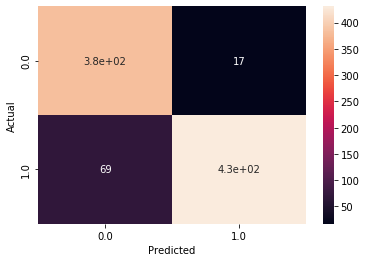

In [25]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

## Combine logits, original sentence, and translations

In [28]:
test['pred'] = test_res['pred']
test['actual'] = test_res['actual']

In [30]:
test.columns = ['sentence1', 'sentence2', 'class', 'pred','actual']

In [31]:
test.head()

,sentence1,sentence2,class,pred,actual
0,जानकारी के मुताबिक जंगलों में पन्द्रह् फरवरी स...,आमतौर पर यहां के जंगलों में 'फायर सीजन' पन्द्र...,P,0.0,0.0
1,20.1 MM बारिश के कारण सड़कों पर 4 फीट तक पानी ...,प्रिंस खलीफा जो की बिन मांझी की खबर पढ़ने के ब...,NP,1.0,1.0
2,20.1 MM बारिश के कारण सड़कों पर 4 फीट तक पानी ...,सड़कों पर 4 फीट तक पानी जमा हो गया था जिसका कार...,P,0.0,0.0
3,DNA टेस्ट से भी रेप की पुष्टि हो चुकी थी।,आरोपी रेप करने के बाद करीब एक साल तक फरार रहा...,NP,1.0,1.0
4,आंतें तक बाहर निकल आई थी|,उन्होंने सीबीआई और प्रवर्तन निदेशालय (ईडी) को ...,NP,1.0,1.0


In [32]:
misclassified_hi_paraphrase  = test[test['pred']!=test['actual'] ][test['class']=='P']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [33]:
misclassified_hi_paraphrase

,sentence1,sentence2,class,pred,actual
11,इसमें लिक्विड प्रोपल्शन टि्वन इंजन लगे हैं।,एडवांस टेक्नोलॉजी वाली पृथ्वी-दो मिसाइल में दो...,P,1.0,0.0
179,इसके साथ ही इसी हफ्ते के अन्त में सीबीआइ ए...,इस सप्ताह के अंत में वह त्यागी के रिश्तेदारों ...,P,1.0,0.0
183,इसरो (भारतीय अंतरिक्ष अनुसंधान संगठन) पहली बार...,आंध्र प्रदेश के श्रीहरिकोटा से आज सुबह पहला स्...,P,1.0,0.0
202,इसे दोबारा से यूज किया जा सकेगा।,ये एक रियूजेबल लॉन्च व्हीकल है,P,1.0,0.0
228,उत्तराखंड में जंगलों में लगी आग के विकराल रूप ...,"उत्तराखंड में एनडीआरएफ, एसडीआरएफ और थलसेना के ...",P,1.0,0.0
257,उन्होंने कहा कि हालिया घटनाक्रम यह दर्शाते है...,'हाल में हुई घटनाएं ये संकेत देती हैं कि मेरे ...,P,1.0,0.0
433,तीन सौ प्च्चास किमी तक मार करने वाली पृथ्वी-द...,भारत ने आज परमाणु क्षमता संपन्न और स्वदेश में ...,P,1.0,0.0
512,"पुलिस ने अनुसार, यह घटना दिन-दहाड़े हुई है",पुलिस को संदेह है कि उस पर दोपहर एक से पांच बज...,P,1.0,0.0
627,मामले में अब तक कोई गिरफ्तारी नहीं हुई है।,मामले में अब तक पुलीस ने किसी को भी अरेस्ट मही...,P,1.0,0.0
741,रियो ओलंपिक के लिए देश का सद्भावना दूत बनेंगे ...,सचिन तेंदुलकर होंगे रियो ओलंपिक के गुडविल ब्रा...,P,1.0,0.0


In [34]:
misclassified_hi_paraphrase.to_csv('../misclassified_hi_paraphrase.csv', sep='\t', encoding='utf-8')

1. There is a lot of entity based context replacement: 'Liquid propulsion' is replaced by 'Advanced technology'
2. 'Brothers' is replaced by the actual names of the brothers in sentence 2


Some common themes why the model is misclassifying are:
1. Contextual replacement of entities 
2. Introduction of entities
3. Mislabeled 

In [ ]:
np.savetxt('../original_sentence-hi.txt', combined['Original_Sentence'], fmt='%s')
np.savetxt('../mBART_translated-hi.txt', combined['mBART_Translated'], fmt='%s')
np.savetxt('../indictrans_translated-hi.txt', combined['IndicTrans_Translated'], fmt='%s')
np.savetxt('../selected_translation-hi.txt', combined['selected_translation'], fmt='%s')

In [ ]:
!cp ../original_sentence-hi.txt ../../bleu_test/testing/indicTrans/
!cp ../mBART_translated-hi.txt  ../../bleu_test/testing/indicTrans/
!cp ../indictrans_translated-hi.txt  ../../bleu_test/testing/indicTrans/
!cp ../selected_translation-hi.txt  ../../bleu_test/testing/indicTrans/